In April 2019 Pregabalin and Gabapentin were reclassified under the misuse of drugs act. This followed the Advisory Committee of Misuse of Drugs recommending reclassification [due to their concerns](https://www.gov.uk/government/news/pregabalin-and-gabapentin-to-be-controlled-as-class-c-drugs) over rising prescribing, misuse and deaths associated with both medicines. The reclassification we intended to bring in stronger controls and reduce the chances of medicines being  used inapprorpiately. 

Tramadol was reclassified for similar reason in 2014 in June 2014 and the [Office of National Statistics reported](https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/bulletins/deathsrelatedtodrugpoisoninginenglandandwales/2015registrations) a 5% drop in tramadol prescribing as well as the first fall in poisoing deaths related to tramadol since the first recorded death.

Therefore we set out to assess if the reclassifciation of Gabapentinoids had similar effect on prescribing.

In [1]:
#import libraries required for analysis
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq


In [2]:
sql='''
SELECT
  month,
  pct_id,
  sum(numerator) as total_gaba,
FROM
  `ebmdatalab.measures.ccg_data_gabapentinoidsddd` AS p
GROUP BY
month,
pct_id
'''

df = bq.cached_read(sql, csv_path='df.csv', use_cache=True)
df['month'] = pd.to_datetime(df['month'])
df.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df.head(5)

,month,pct,total_gaba
0,2019-04-01,08P,31527.222222
1,2018-12-01,08P,33296.233333
2,2017-08-01,08P,30987.561111
3,2018-02-01,08P,29904.100000
4,2018-11-01,08P,33234.388889


(0, 35000000)

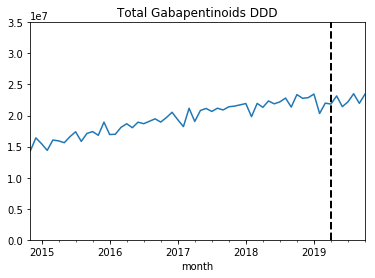

In [3]:
ax = df.groupby(["month"])['total_gaba'].sum().plot(kind='line', title="Total Gabapentinoids DDD")
ax.axvline(pd.to_datetime('2019-04-01'), color='black', linestyle='--', lw=2) ##law change
plt.ylim(0, 35000000 )

The data for 12 months followup will be with us in June 2020 so we should aim to have paper finalised before this, with aim of submitting x hours after publication of data.

**Possible To do:**
- The break detection thing to see if anyone really changed?
- Computer system differences? (the decrease in Jan/Feb 2019 was caused by EHRs implementing the controlled drug controls in this month earlier than legal changes) 
- Factors associated with higher prescribing?
- Top 10 CCGs?


##  EHR Changes

NHS Digital helpfully [published all "go live" dates](https://web.archive.org/save/https://digital.nhs.uk/services/electronic-prescription-service/controlled-drugs/eps-updates-to-reflect-the-reclassification-of-pregabalin-and-gabapentin) for Gabapentin and Pregabalin reclassifcations on their website.

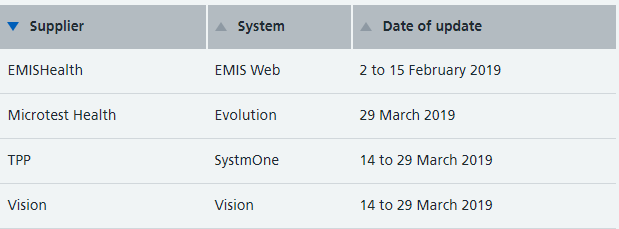

In [4]:
sql = '''SELECT
  p.month,
  p.pct_id,
  p.practice_id,
  TRIM(Principal_Supplier) AS supplier,
  sum(numerator) as total_gaba,
FROM
  `ebmdatalab.measures.practice_data_gabapentinoidsddd` AS p
JOIN
  ebmdatalab.alex.vendors as software #this is where the up to date vendors table is held
ON
  software.ODS = practice_id
  AND DATE(Date) = p.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = practice_statistics.month
WHERE
total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0 
GROUP BY
month,
pct_id,
p.practice_id,
supplier,
numerator'''

df_ehr = bq.cached_read(sql, csv_path='df_ehr.csv', use_cache=True)
df_ehr['month'] = pd.to_datetime(df_ehr['month'])
df_ehr.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df_ehr.head(5)








,month,pct,practice_id,supplier,total_gaba
0,2016-02-01,00K,A81001,TPP,2255.777778
1,2017-08-01,00K,A81001,TPP,2913.055556
2,2016-03-01,00K,A81001,TPP,2405.277778
3,2016-04-01,00K,A81001,TPP,2401.388889
4,2019-05-01,00K,A81001,TPP,2863.444444


In [5]:
ehr_gaba = df_ehr.groupby(['month','supplier'])['total_gaba'].sum().reset_index()
ehr_gaba.head(5)

,month,supplier,total_gaba
0,2016-01-01,EMIS,8.522245e+06
1,2016-01-01,INPS,1.209689e+06
2,2016-01-01,Microtest,2.381984e+05
3,2016-01-01,TPP,5.714141e+06
4,2016-01-01,Unknown,4.353556e+03


Text(0.5,1,'Total Gabapentinoids DDD per EHR Vendor')

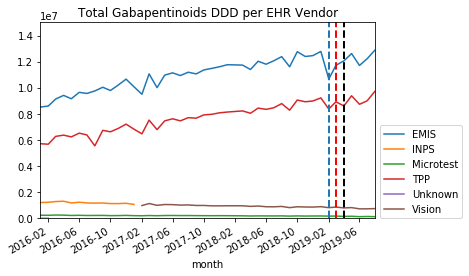

In [6]:
ax = df_ehr.groupby(['month', 'supplier']).sum()['total_gaba'].unstack().plot.line()
ax.axvline(pd.to_datetime('2019-04-01'), color='black', linestyle='--', lw=2) ##law change
ax.axvline(pd.to_datetime('2019-01-31'), color='#1f77b4', linestyle='--', lw=2) ##emis change
ax.axvline(pd.to_datetime('2019-03-01'), color='red', linestyle='--', lw=2) ##tpp change
plt.legend(loc='best', bbox_to_anchor=(1, 0.5))
plt.ylim(0, 15000000 )
plt.title("Total Gabapentinoids DDD per EHR Vendor")

Some thoughts:
- We can see a large drop in EMIS in February but also a drop in items for SystmOne, problably reflective of less dispensing days in February. To control for that we could look at DDD per disp day, DDD per disp day, items etc. NB to discuss with team.

- There is no corresponding drop off for SystmOne prior to it being made a CD. Maybe the controls are weaker for CD prescribing on SystmOne??

- We could also look at tramadol for reclassication story - ONS might've got it wrong, we could also see EHR picture at the time. We have no measure of tramadol on the site so need to do DDD/mg/QTY/items